In [1]:
# Imports we will use
import torch
import gc
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import random
from pathlib import Path
from sklearn.metrics import r2_score
from astropy.visualization import make_lupton_rgb
from sklearn.manifold import Isomap
from train_utils import *
import time
import os
import json

%matplotlib inline
plt.rcParams.update({'font.size': 12})

# Find if cuda is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [2]:
#fix seed
seed = 12
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.enabled=False
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(seed)

## Load Data

In [3]:
# Specify paths, load in data, and subsample labels
head = Path.cwd().parents[1]
source_img_path = head / 'data/mb_paper_source_final/mb_paper_source_final.npy'
target_img_path = head / 'data/mb_paper_target_final/mb_paper_target_final.npy'
source_meta = head / 'data/mb_paper_source_final/mb_paper_source_final_metadata.csv'
target_meta = head / 'data/mb_paper_target_final/mb_paper_target_final_metadata.csv'
batch_size = 128
source_train_dataloader, source_test_dataloader, source_val_dataloader, source_data = create_dataloader(source_img_path, source_meta, batch_size)
target_train_dataloader, target_test_dataloader, target_val_dataloader, target_data = create_dataloader(target_img_path, target_meta, batch_size)
isomap_source_label_sample = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
isomap_target_label_sample = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

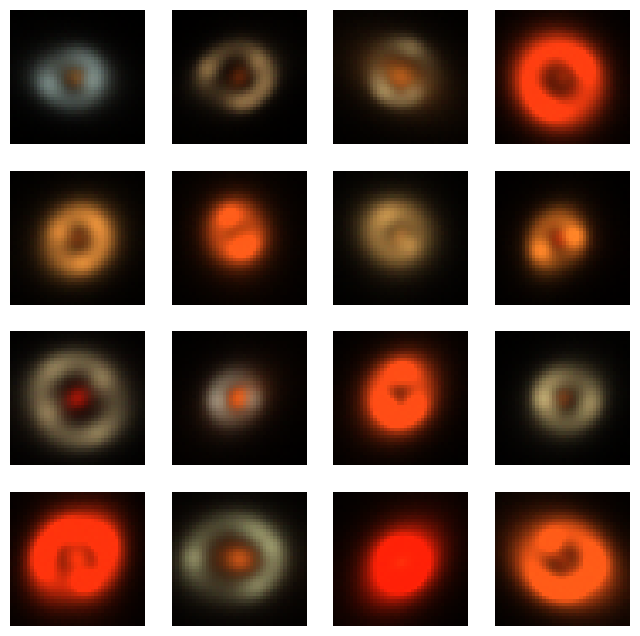

In [4]:
# Visualize source data
visualize_data(source_data)

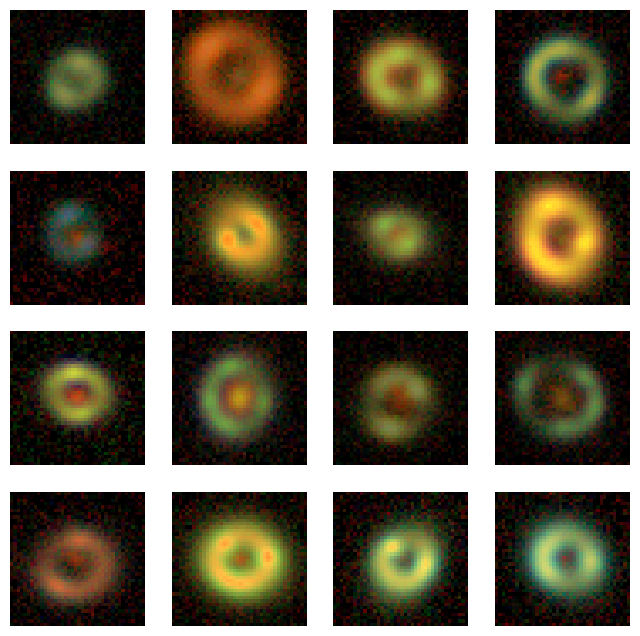

In [5]:
# Visualize target data
visualize_data(target_data)

## Model Setup

In [6]:
# Choose how you prefer to evolve beta and the DA Weight
def da_weight_function(epoch):
    """ Linear evolving DA weighting in loss function. """
    if epoch < evolv_epoch:
        da_weight = init_wt_da - ((init_wt_da - final_wt_da) * (epoch / n_epoch))
    else:
        da_weight = final_wt_da
    return 0.0

def beta_function(epoch):
    """ Linear evolving beta weighting in loss function until halfway through total epochs. """
    if epoch < evolv_epoch:
        beta_val = beta_init - (beta_init - beta_final) * (epoch / evolv_epoch)
    else:
        beta_val = beta_final
    return beta_val

# Initialize hyperparameters
learning_rate = 1e-5
n_epoch = 300

evolv_epoch = 250
init_wt_da = 0.0
final_wt_da = 1.0
beta_init = 1.0
beta_final = 0.0

In [7]:
from torch.optim.lr_scheduler import MultiStepLR
# Initialize model
model = NeuralNetworkMVE(npix=40).cuda()

# Loss Functions / Optimizers
regressor_loss_fn = nn.MSELoss().cuda()
da_loss_fn = MMD_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = MultiStepLR(optimizer, milestones=[100, 200, 250, 275], gamma=0.5)

In [8]:
# To continue training from a past model, enter path into load_mod_name
# Else, enter None, and you still have to run the function.
# Then, enter save_mod_name to save for the current run  

load_mod_name = None #"models/papermve_v1_aug20_1940_A" # "models/start_code_test_2"
stats, model, optimizer, best_target_R2, best_mve_loss = initialize_state(load_mod_name, model, optimizer)


#save_mod_name = load_mod_name # may overwrite loaded model
save_mod_name = "models/papermve_noda_v3_aug22_2300_B"

## Train

Beginning Training...
Generating Isomap...


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


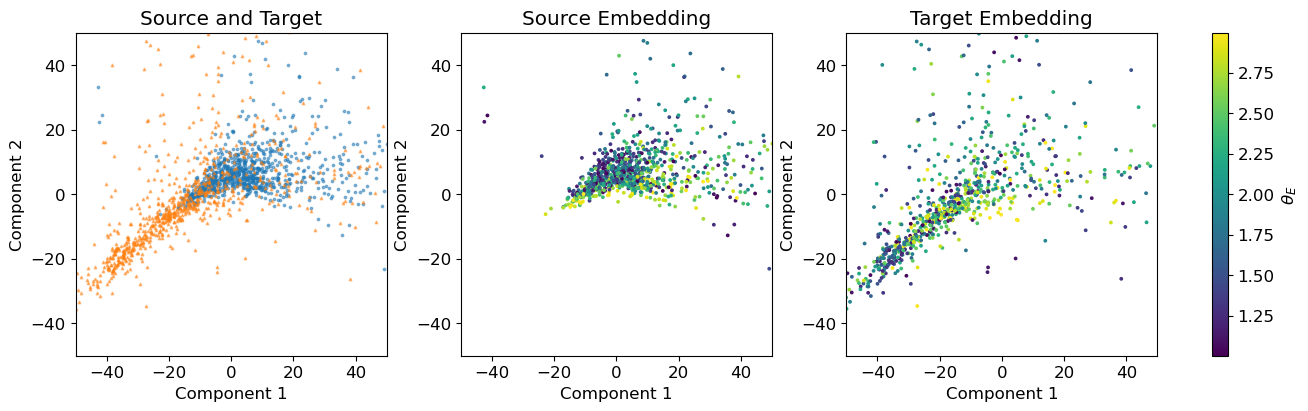


Epoch 0: 43.60s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3311
	Train Regression Loss: : 2.4654
	Train Mve Loss: : 1.0800
	Train R2 Score: : -6.4873
 Validation Statistics:
	Val Source Regression Loss: : 1.7938
	Val Target Regression Loss: : 1.7300
	Val Source R2 Score: : -4.5522
	Val Target R2 Score: : -4.1798
	Val Source Mve Loss: : 0.7233
	Val Target Mve Loss: : 0.6881
Saving Model MVE... Done.

Epoch 1: 44.14s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3328
	Train Regression Loss: : 1.3149
	Train Mve Loss: : 0.4866
	Train R2 Score: : -2.9779
 Validation Statistics:
	Val Source Regression Loss: : 0.9241
	Val Target Regression Loss: : 0.8945
	Val Source R2 Score: : -1.8274
	Val Target R2 Score: : -1.6611
	Val Source Mve Loss: : 0.2918
	Val Target Mve Loss: : 0.2780
Saving Model MVE... Done.

Epoch 2: 40.28s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3333
	Train Regression Loss: : 0.6927
	Tr

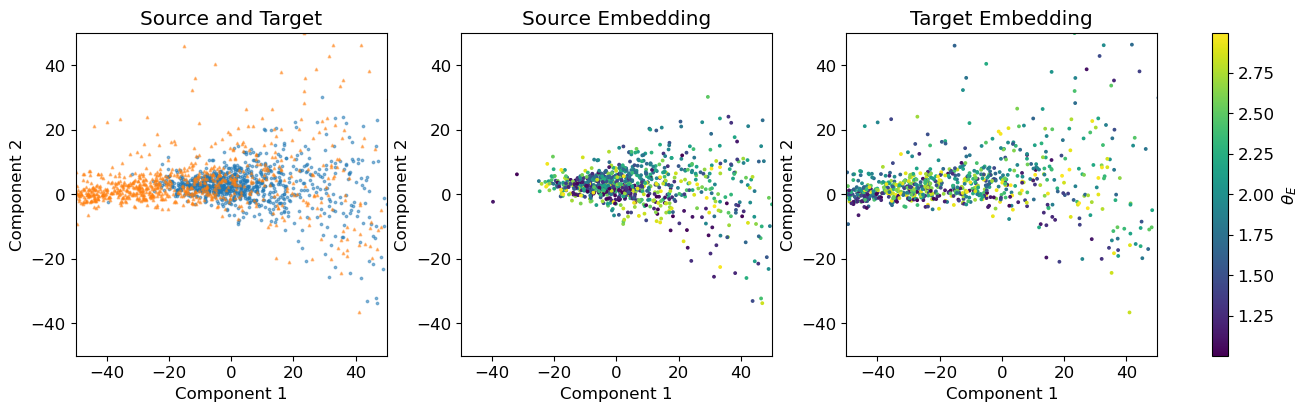


Epoch 20: 46.54s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3464
	Train Regression Loss: : 0.0267
	Train Mve Loss: : -0.0752
	Train R2 Score: : 0.9189
 Validation Statistics:
	Val Source Regression Loss: : 0.0266
	Val Target Regression Loss: : 0.1311
	Val Source R2 Score: : 0.9180
	Val Target R2 Score: : 0.6124
	Val Source Mve Loss: : -0.0784
	Val Target Mve Loss: : -0.0466

Epoch 21: 41.36s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3482
	Train Regression Loss: : 0.0260
	Train Mve Loss: : -0.0673
	Train R2 Score: : 0.9212
 Validation Statistics:
	Val Source Regression Loss: : 0.0258
	Val Target Regression Loss: : 0.1334
	Val Source R2 Score: : 0.9211
	Val Target R2 Score: : 0.6044
	Val Source Mve Loss: : -0.1059
	Val Target Mve Loss: : -0.0701
Saving Model MVE... Done.

Epoch 22: 39.66s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3493
	Train Regression Loss: : 0.0250
	Train Mve Loss: : -0.0853

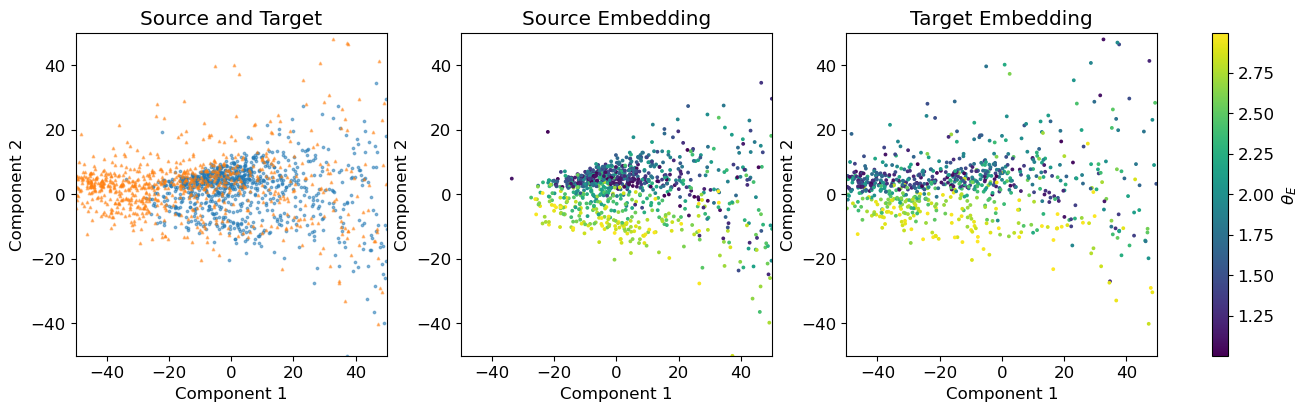


Epoch 40: 41.48s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3366
	Train Regression Loss: : 0.0190
	Train Mve Loss: : -0.1119
	Train R2 Score: : 0.9424
 Validation Statistics:
	Val Source Regression Loss: : 0.0192
	Val Target Regression Loss: : 0.1385
	Val Source R2 Score: : 0.9416
	Val Target R2 Score: : 0.5912
	Val Source Mve Loss: : -0.1120
	Val Target Mve Loss: : -0.0396

Epoch 41: 48.00s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3412
	Train Regression Loss: : 0.0188
	Train Mve Loss: : -0.1091
	Train R2 Score: : 0.9431
 Validation Statistics:
	Val Source Regression Loss: : 0.0188
	Val Target Regression Loss: : 0.1410
	Val Source R2 Score: : 0.9425
	Val Target R2 Score: : 0.5814
	Val Source Mve Loss: : -0.1192
	Val Target Mve Loss: : -0.0399

Epoch 43: 42.50s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3415
	Train Regression Loss: : 0.0187
	Train Mve Loss: : -0.1553
	Train R2 Score: : 0.9435

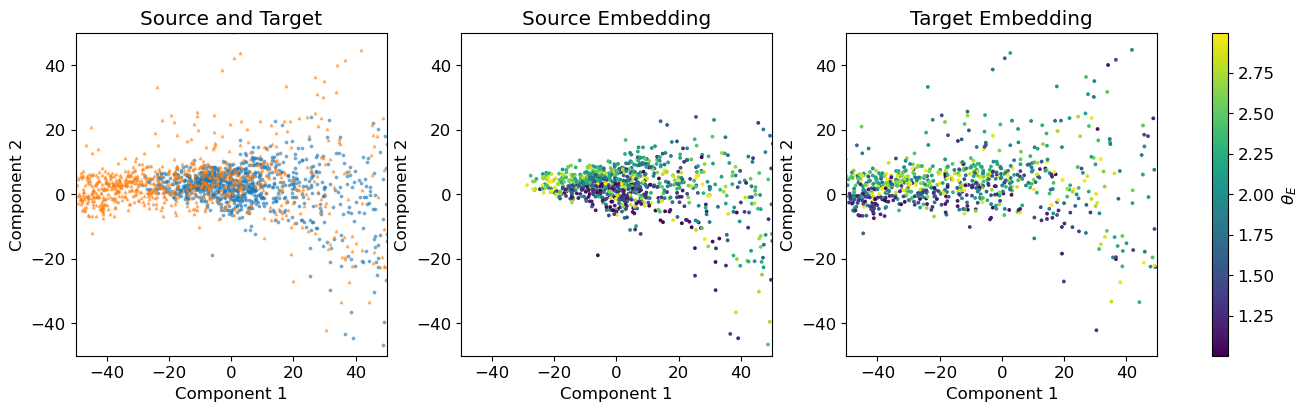


Epoch 60: 40.34s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3372
	Train Regression Loss: : 0.0165
	Train Mve Loss: : -0.1723
	Train R2 Score: : 0.9498
 Validation Statistics:
	Val Source Regression Loss: : 0.0169
	Val Target Regression Loss: : 0.1571
	Val Source R2 Score: : 0.9483
	Val Target R2 Score: : 0.5352
	Val Source Mve Loss: : -0.1443
	Val Target Mve Loss: : 0.1473

Epoch 61: 44.38s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3346
	Train Regression Loss: : 0.0164
	Train Mve Loss: : -0.1286
	Train R2 Score: : 0.9501
 Validation Statistics:
	Val Source Regression Loss: : 0.0167
	Val Target Regression Loss: : 0.1533
	Val Source R2 Score: : 0.9488
	Val Target R2 Score: : 0.5466
	Val Source Mve Loss: : -0.1401
	Val Target Mve Loss: : 0.1547

Epoch 62: 51.92s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3396
	Train Regression Loss: : 0.0164
	Train Mve Loss: : -0.1224
	Train R2 Score: : 0.9502
 

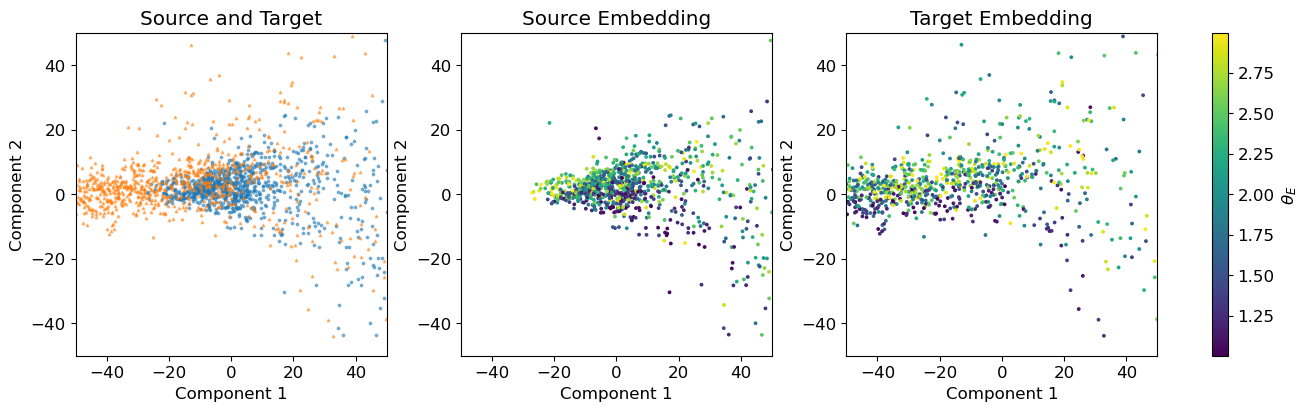


Epoch 80: 43.97s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3217
	Train Regression Loss: : 0.0146
	Train Mve Loss: : -0.2142
	Train R2 Score: : 0.9557
 Validation Statistics:
	Val Source Regression Loss: : 0.0148
	Val Target Regression Loss: : 0.1647
	Val Source R2 Score: : 0.9545
	Val Target R2 Score: : 0.5077
	Val Source Mve Loss: : -0.2122
	Val Target Mve Loss: : -0.0602

Epoch 81: 43.26s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3215
	Train Regression Loss: : 0.0146
	Train Mve Loss: : -0.1998
	Train R2 Score: : 0.9558
 Validation Statistics:
	Val Source Regression Loss: : 0.0149
	Val Target Regression Loss: : 0.1578
	Val Source R2 Score: : 0.9543
	Val Target R2 Score: : 0.5308
	Val Source Mve Loss: : -0.1794
	Val Target Mve Loss: : 0.1066

Epoch 82: 42.07s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3208
	Train Regression Loss: : 0.0144
	Train Mve Loss: : -0.1828
	Train R2 Score: : 0.9562


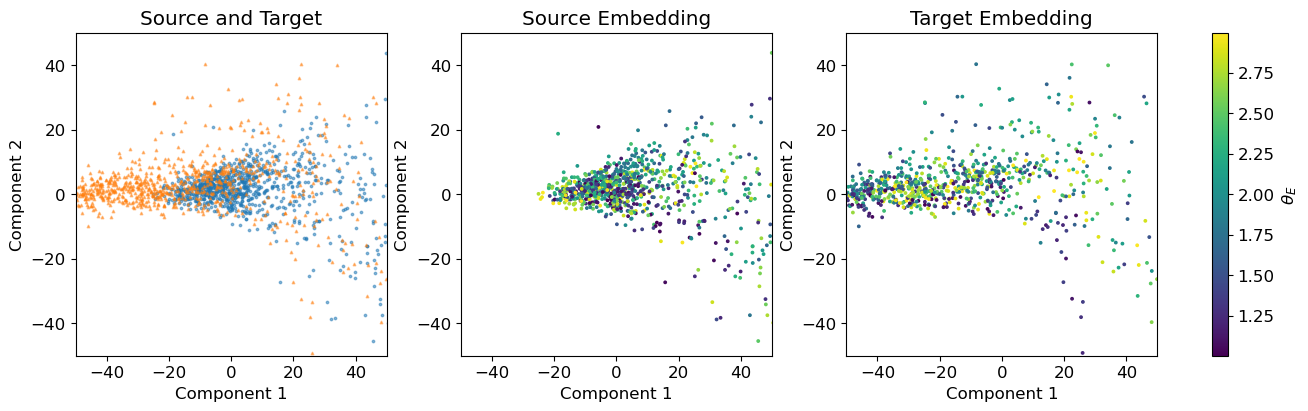


Epoch 100: 38.55s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3269
	Train Regression Loss: : 0.0142
	Train Mve Loss: : -0.2793
	Train R2 Score: : 0.9569
 Validation Statistics:
	Val Source Regression Loss: : 0.0143
	Val Target Regression Loss: : 0.1728
	Val Source R2 Score: : 0.9561
	Val Target R2 Score: : 0.4852
	Val Source Mve Loss: : -0.2734
	Val Target Mve Loss: : 0.1930

Epoch 101: 47.93s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3245
	Train Regression Loss: : 0.0142
	Train Mve Loss: : -0.2799
	Train R2 Score: : 0.9568
 Validation Statistics:
	Val Source Regression Loss: : 0.0144
	Val Target Regression Loss: : 0.1699
	Val Source R2 Score: : 0.9557
	Val Target R2 Score: : 0.4957
	Val Source Mve Loss: : -0.2682
	Val Target Mve Loss: : 0.1972

Epoch 102: 44.22s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3276
	Train Regression Loss: : 0.0143
	Train Mve Loss: : -0.2872
	Train R2 Score: : 0.956

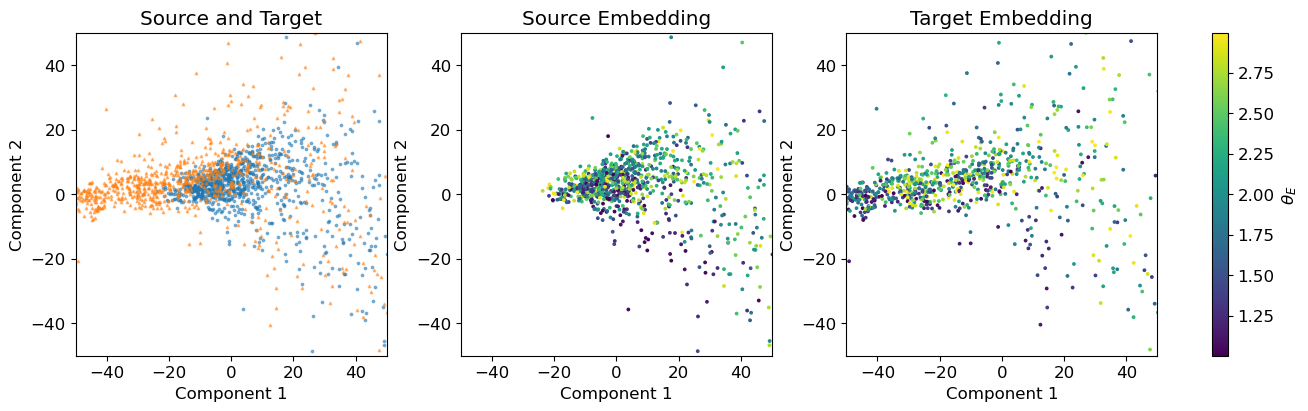


Epoch 120: 41.17s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3289
	Train Regression Loss: : 0.0139
	Train Mve Loss: : -0.2561
	Train R2 Score: : 0.9578
 Validation Statistics:
	Val Source Regression Loss: : 0.0144
	Val Target Regression Loss: : 0.1598
	Val Source R2 Score: : 0.9550
	Val Target R2 Score: : 0.5234
	Val Source Mve Loss: : -0.2824
	Val Target Mve Loss: : 1.4272

Epoch 121: 37.75s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3270
	Train Regression Loss: : 0.0137
	Train Mve Loss: : -0.2195
	Train R2 Score: : 0.9584
 Validation Statistics:
	Val Source Regression Loss: : 0.0143
	Val Target Regression Loss: : 0.1672
	Val Source R2 Score: : 0.9561
	Val Target R2 Score: : 0.4978
	Val Source Mve Loss: : -0.3177
	Val Target Mve Loss: : 0.9783

Epoch 122: 45.06s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3260
	Train Regression Loss: : 0.0137
	Train Mve Loss: : -0.3198
	Train R2 Score: : 0.958

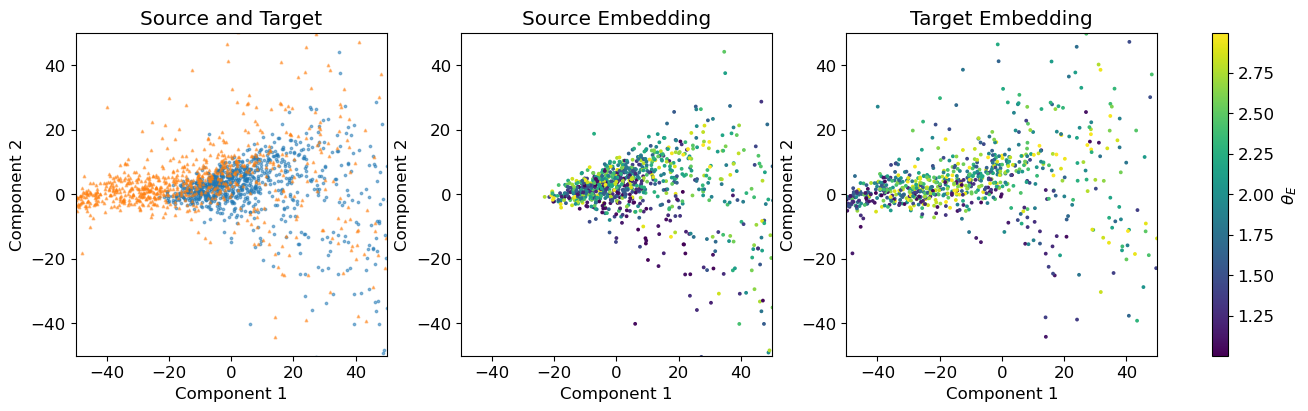


Epoch 140: 40.86s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3241
	Train Regression Loss: : 0.0137
	Train Mve Loss: : -0.2500
	Train R2 Score: : 0.9585
 Validation Statistics:
	Val Source Regression Loss: : 0.0139
	Val Target Regression Loss: : 0.1615
	Val Source R2 Score: : 0.9570
	Val Target R2 Score: : 0.5206
	Val Source Mve Loss: : -0.3080
	Val Target Mve Loss: : 6.7788

Epoch 141: 53.27s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3260
	Train Regression Loss: : 0.0136
	Train Mve Loss: : -0.3338
	Train R2 Score: : 0.9587
 Validation Statistics:
	Val Source Regression Loss: : 0.0141
	Val Target Regression Loss: : 0.1625
	Val Source R2 Score: : 0.9568
	Val Target R2 Score: : 0.5155
	Val Source Mve Loss: : -0.3154
	Val Target Mve Loss: : 8.7593

Epoch 142: 47.37s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3258
	Train Regression Loss: : 0.0137
	Train Mve Loss: : -0.3477
	Train R2 Score: : 0.958

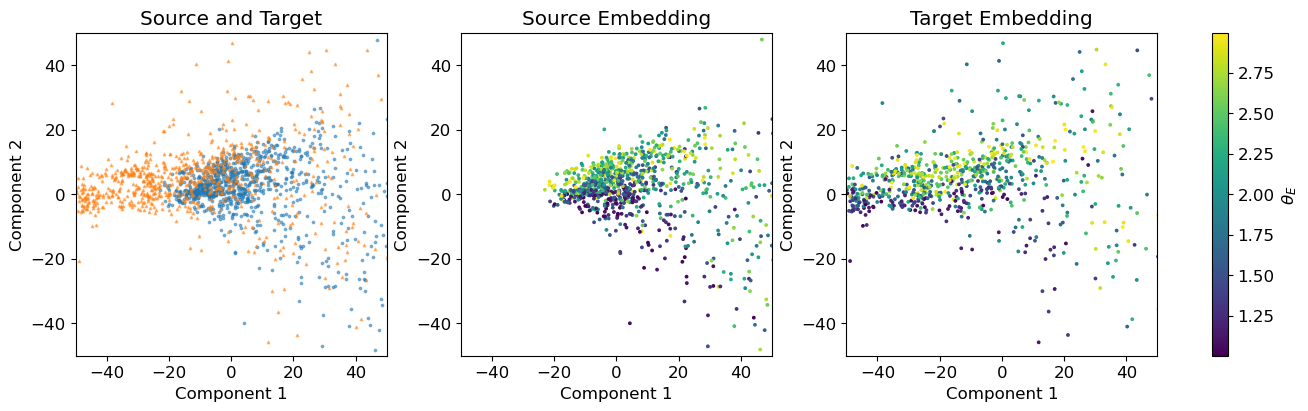


Epoch 160: 41.17s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3231
	Train Regression Loss: : 0.0134
	Train Mve Loss: : -0.4517
	Train R2 Score: : 0.9595
 Validation Statistics:
	Val Source Regression Loss: : 0.0145
	Val Target Regression Loss: : 0.1624
	Val Source R2 Score: : 0.9553
	Val Target R2 Score: : 0.5171
	Val Source Mve Loss: : -0.3904
	Val Target Mve Loss: : 7.8338

Epoch 161: 43.88s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3244
	Train Regression Loss: : 0.0134
	Train Mve Loss: : -0.4330
	Train R2 Score: : 0.9592
 Validation Statistics:
	Val Source Regression Loss: : 0.0141
	Val Target Regression Loss: : 0.1570
	Val Source R2 Score: : 0.9571
	Val Target R2 Score: : 0.5304
	Val Source Mve Loss: : -0.2921
	Val Target Mve Loss: : 15.6000

Epoch 162: 45.71s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3235
	Train Regression Loss: : 0.0133
	Train Mve Loss: : -0.4143
	Train R2 Score: : 0.95

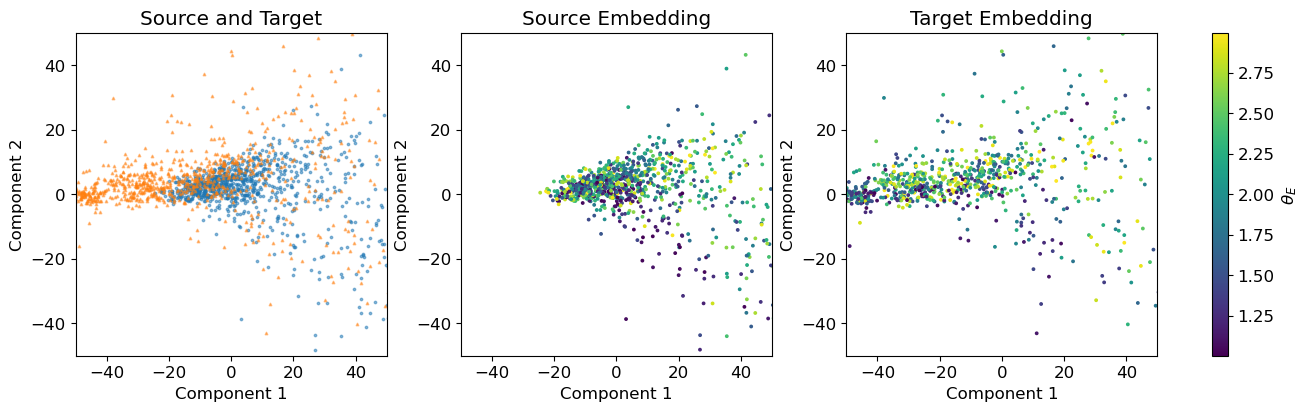


Epoch 180: 43.07s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3193
	Train Regression Loss: : 0.0142
	Train Mve Loss: : 1.1047
	Train R2 Score: : 0.9572
 Validation Statistics:
	Val Source Regression Loss: : 0.0152
	Val Target Regression Loss: : 0.1402
	Val Source R2 Score: : 0.9536
	Val Target R2 Score: : 0.5823
	Val Source Mve Loss: : 1.7147
	Val Target Mve Loss: : 53.6887

Epoch 181: 43.31s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3185
	Train Regression Loss: : 0.0142
	Train Mve Loss: : -0.3396
	Train R2 Score: : 0.9570
 Validation Statistics:
	Val Source Regression Loss: : 0.0146
	Val Target Regression Loss: : 0.1473
	Val Source R2 Score: : 0.9556
	Val Target R2 Score: : 0.5627
	Val Source Mve Loss: : 0.0900
	Val Target Mve Loss: : 62.4424

Epoch 182: 47.81s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3194
	Train Regression Loss: : 0.0142
	Train Mve Loss: : 0.0747
	Train R2 Score: : 0.9570


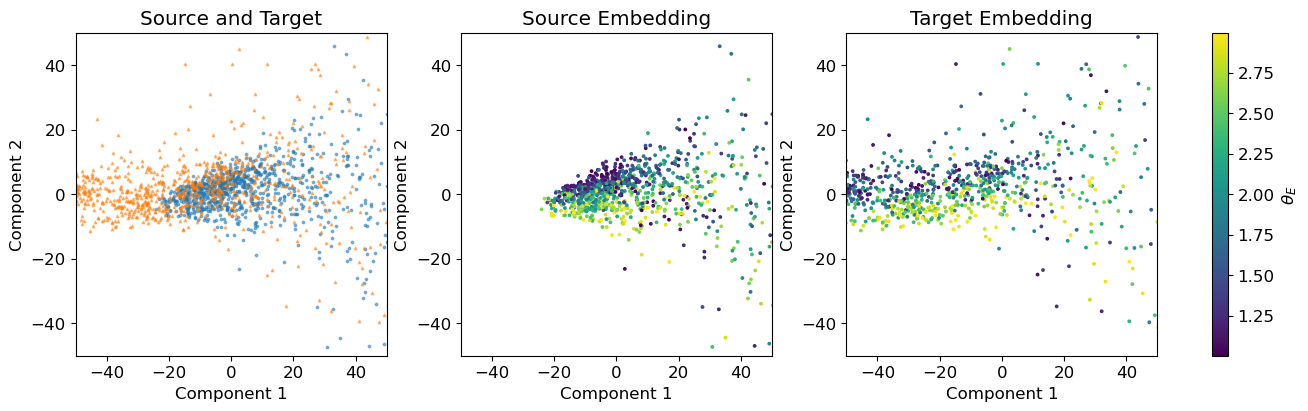


Epoch 200: 44.09s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3199
	Train Regression Loss: : 0.0141
	Train Mve Loss: : -0.3336
	Train R2 Score: : 0.9571
 Validation Statistics:
	Val Source Regression Loss: : 0.0143
	Val Target Regression Loss: : 0.1538
	Val Source R2 Score: : 0.9559
	Val Target R2 Score: : 0.5374
	Val Source Mve Loss: : -0.2672
	Val Target Mve Loss: : 2.7539

Epoch 201: 46.48s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3209
	Train Regression Loss: : 0.0139
	Train Mve Loss: : -0.2831
	Train R2 Score: : 0.9579
 Validation Statistics:
	Val Source Regression Loss: : 0.0144
	Val Target Regression Loss: : 0.1519
	Val Source R2 Score: : 0.9556
	Val Target R2 Score: : 0.5496
	Val Source Mve Loss: : 0.4030
	Val Target Mve Loss: : 61.7166

Epoch 202: 42.71s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3212
	Train Regression Loss: : 0.0138
	Train Mve Loss: : -0.0110
	Train R2 Score: : 0.958

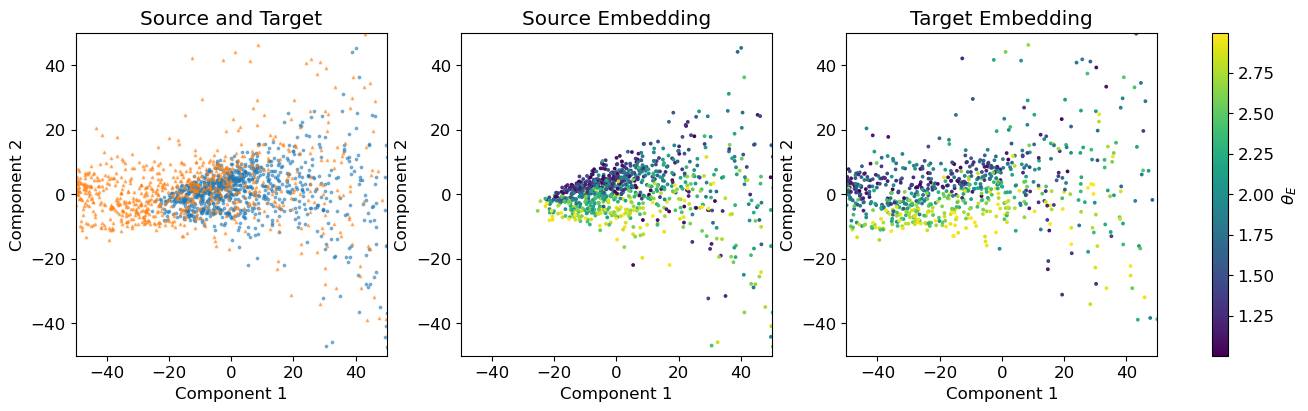


Epoch 220: 42.06s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3194
	Train Regression Loss: : 0.0130
	Train Mve Loss: : -0.2733
	Train R2 Score: : 0.9607
 Validation Statistics:
	Val Source Regression Loss: : 0.0135
	Val Target Regression Loss: : 0.1371
	Val Source R2 Score: : 0.9587
	Val Target R2 Score: : 0.5897
	Val Source Mve Loss: : 3.5402
	Val Target Mve Loss: : 237.3593

Epoch 221: 43.73s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3185
	Train Regression Loss: : 0.0132
	Train Mve Loss: : -0.3150
	Train R2 Score: : 0.9599
 Validation Statistics:
	Val Source Regression Loss: : 0.0136
	Val Target Regression Loss: : 0.1355
	Val Source R2 Score: : 0.9586
	Val Target R2 Score: : 0.5960
	Val Source Mve Loss: : 4.0517
	Val Target Mve Loss: : 731.4314

Epoch 222: 40.57s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3161
	Train Regression Loss: : 0.0135
	Train Mve Loss: : 2.9313
	Train R2 Score: : 0.95

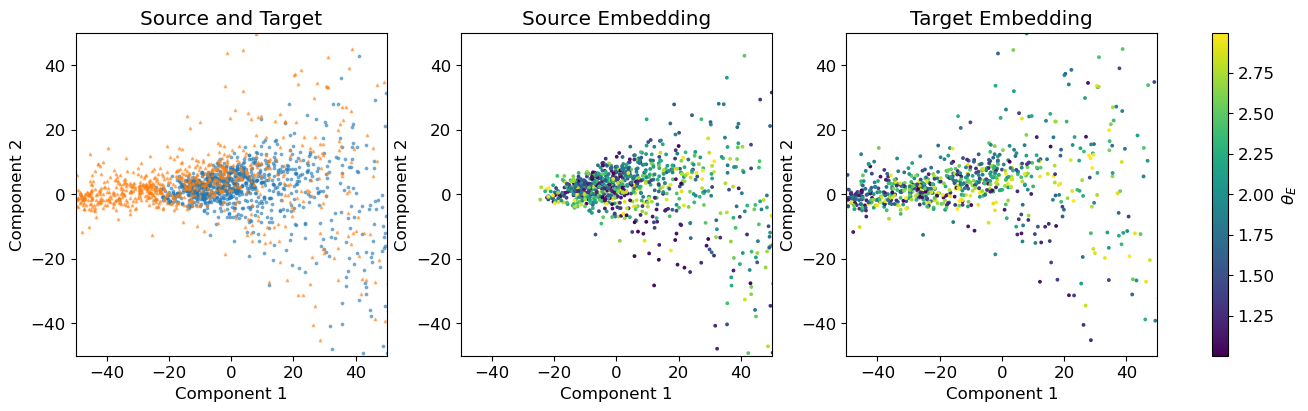


Epoch 240: 43.81s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3194
	Train Regression Loss: : 0.0131
	Train Mve Loss: : 15.1345
	Train R2 Score: : 0.9603
 Validation Statistics:
	Val Source Regression Loss: : 0.0136
	Val Target Regression Loss: : 0.1393
	Val Source R2 Score: : 0.9583
	Val Target R2 Score: : 0.5857
	Val Source Mve Loss: : 31.7704
	Val Target Mve Loss: : 3040.9559

Epoch 241: 46.40s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3213
	Train Regression Loss: : 0.0132
	Train Mve Loss: : 26.3759
	Train R2 Score: : 0.9599
 Validation Statistics:
	Val Source Regression Loss: : 0.0136
	Val Target Regression Loss: : 0.1435
	Val Source R2 Score: : 0.9582
	Val Target R2 Score: : 0.5727
	Val Source Mve Loss: : 25.3759
	Val Target Mve Loss: : 1917.2985

Epoch 242: 48.13s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3201
	Train Regression Loss: : 0.0133
	Train Mve Loss: : 31.9866
	Train R2 Score: :

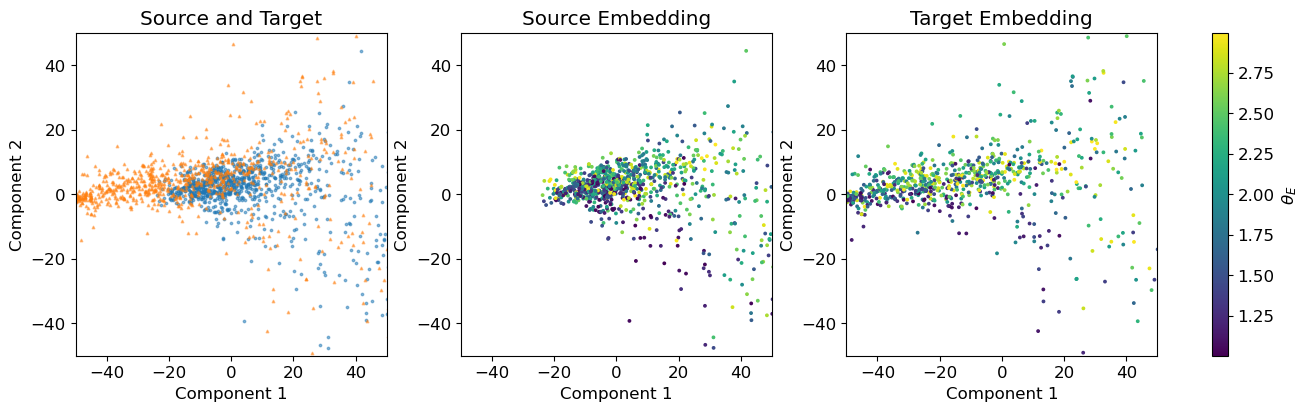


Epoch 260: 40.46s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3213
	Train Regression Loss: : 0.0132
	Train Mve Loss: : 16.9249
	Train R2 Score: : 0.9600
 Validation Statistics:
	Val Source Regression Loss: : 0.0135
	Val Target Regression Loss: : 0.1429
	Val Source R2 Score: : 0.9586
	Val Target R2 Score: : 0.5746
	Val Source Mve Loss: : 141.5785
	Val Target Mve Loss: : 5676.0394

Epoch 261: 42.07s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3227
	Train Regression Loss: : 0.0132
	Train Mve Loss: : 15.7073
	Train R2 Score: : 0.9599
 Validation Statistics:
	Val Source Regression Loss: : 0.0136
	Val Target Regression Loss: : 0.1410
	Val Source R2 Score: : 0.9583
	Val Target R2 Score: : 0.5762
	Val Source Mve Loss: : 56.2930
	Val Target Mve Loss: : 6409.4051

Epoch 262: 40.58s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3222
	Train Regression Loss: : 0.0132
	Train Mve Loss: : 20.7687
	Train R2 Score: 

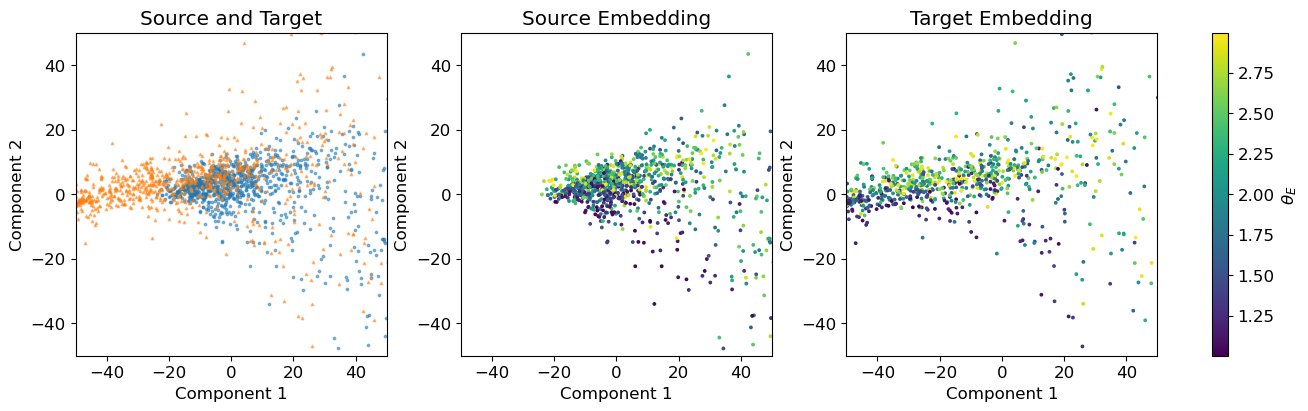


Epoch 280: 41.72s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3199
	Train Regression Loss: : 0.0131
	Train Mve Loss: : 36.3009
	Train R2 Score: : 0.9603
 Validation Statistics:
	Val Source Regression Loss: : 0.0133
	Val Target Regression Loss: : 0.1381
	Val Source R2 Score: : 0.9594
	Val Target R2 Score: : 0.5896
	Val Source Mve Loss: : 472.5319
	Val Target Mve Loss: : 5080.5956

Epoch 281: 44.53s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3199
	Train Regression Loss: : 0.0132
	Train Mve Loss: : 8.8151
	Train R2 Score: : 0.9600
 Validation Statistics:
	Val Source Regression Loss: : 0.0137
	Val Target Regression Loss: : 0.1388
	Val Source R2 Score: : 0.9573
	Val Target R2 Score: : 0.5860
	Val Source Mve Loss: : 72.8985
	Val Target Mve Loss: : 3685.3638

Epoch 282: 45.24s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3195
	Train Regression Loss: : 0.0132
	Train Mve Loss: : 22.1735
	Train R2 Score: :

In [9]:
print("Beginning Training...")

stats['lr'] = []
for curr_epoch in range(stats['epoch_no'], stats['epoch_no'] + n_epoch):

        # Generate isomaps every 20 epochs
        if (curr_epoch % 20 == 0):
            print("Generating Isomap...")
            source_iso, target_iso = generate_isomaps(source_data, target_data, model)
            show_isomaps(source_iso, 
                         target_iso, 
                         isomap_source_label_sample, 
                         isomap_target_label_sample, 
                         save_mod_name, 
                         name = stats["epoch_no"], 
                         axlim = 50, save = True)

        # Save best models
        if (len(stats['val_target_r2_score']) > 0):
            
            # Save and overwrite model every best target R2
            if (stats['val_target_r2_score'][-1] > best_target_R2):
                print("Saving Model...", end = ' ')
                save_model(save_mod_name, model, optimizer, stats)
                best_target_R2 = stats['val_target_r2_score'][-1]
                print("Done.")
                
            # Save and overwrite model every best target MVE Loss
            if (stats['val_target_mve_loss'][-1] < best_mve_loss):
                print("Saving Model MVE...", end = ' ')
                mve_name = save_mod_name + "_mve"
                save_model(mve_name, model, optimizer, stats)
                best_mve_loss = stats['val_target_mve_loss'][-1]
                print("Done.")

            if ((curr_epoch > 250) and (stats['val_target_r2_score'][-1] > 0.95) and (stats['val_target_mve_loss'][-1] < -1)):
                print("Saving Model Minima...", end = ' ')
                m_name = save_mod_name + f"_{curr_epoch}"
                save_model(m_name, model, optimizer, stats)
                print("Done.")

        
        start_time = time.time()

        beta = beta_function(curr_epoch)
        da_weight = da_weight_function(curr_epoch)

        # Train, backpropagate
        vals = train_loop_mve(source_train_dataloader, 
                              target_train_dataloader, 
                              model,
                              regressor_loss_fn, 
                              da_loss_fn, 
                              optimizer,
                              da_weight, 
                              beta)

        # Test, validate metrics
        vals_validate = test_loop_mve(source_val_dataloader, 
                                      target_val_dataloader,
                                      model, 
                                      regressor_loss_fn, 
                                      beta)

        scheduler.step()

        # Training Metrics
        stats['train_DA_loss'].append(vals[0])
        stats['train_regression_loss'].append(vals[1])
        stats['train_mve_loss'].append(vals[2])
        stats['train_r2_score'].append(vals[3])

        # Validation Metrics
        stats['val_source_regression_loss'].append(vals_validate[0])
        stats['val_target_regression_loss'].append(vals_validate[1])
        stats['val_source_r2_score'].append(vals_validate[2])
        stats['val_target_r2_score'].append(vals_validate[3])
        stats['val_source_mve_loss'].append(vals_validate[4])
        stats['val_target_mve_loss'].append(vals_validate[5])
        
        # Other Parameters
        stats['da_weight'].append(da_weight)
        stats['beta'].append(beta)
        stats['epoch_no'] += 1
        stats['lr'].append(scheduler.get_last_lr())
        print_epoch_scores(stats, curr_epoch, time.time() - start_time)

In [10]:
# Saves the end result model after running for all stages, as well as the .json of stats

state = {
    'epoch': stats['epoch_no'],
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}
final_mod_name = save_mod_name + "_final"
torch.save(state, final_mod_name)
json.dump(stats, open(final_mod_name+'.json', 'w'))

## Visualize Results

In [34]:
# Loads a model for plotting/viz

viz_mod_name = "models/papermve_v3_aug22_1315_A_mve" # "models/start_code_test_4_final"
model.load_state_dict(torch.load(viz_mod_name)['state_dict'])
stats = json.load(open(viz_mod_name+'.json', 'r'))

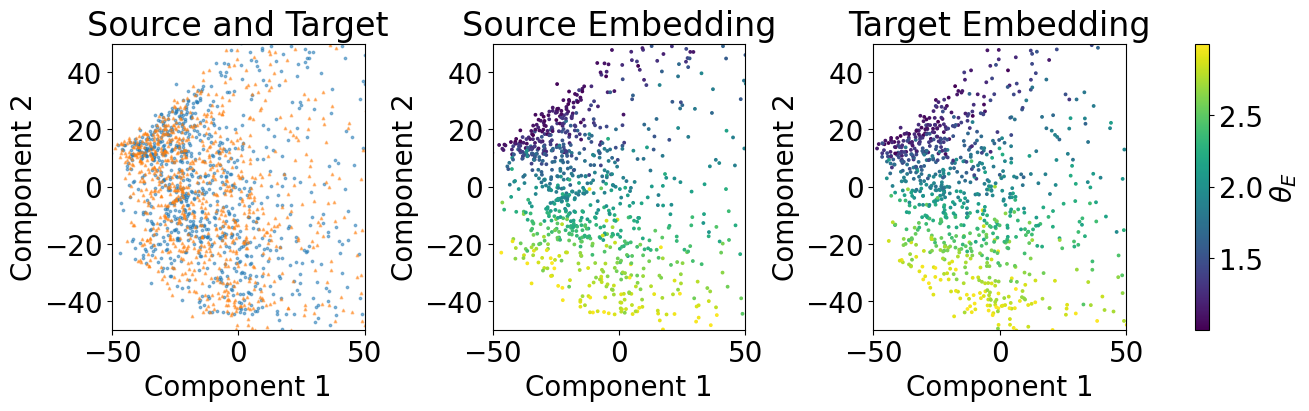

(<Figure size 1300x400 with 4 Axes>,
 array([<Axes: title={'center': 'Source and Target'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Source Embedding'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Target Embedding'}, xlabel='Component 1', ylabel='Component 2'>],
       dtype=object))

In [35]:
# Visualize isomaps 
trained_source_iso, trained_target_iso = generate_isomaps(source_data, target_data, model)
show_isomaps(trained_source_iso, trained_target_iso, isomap_source_label_sample, isomap_target_label_sample, viz_mod_name, axlim = 50)

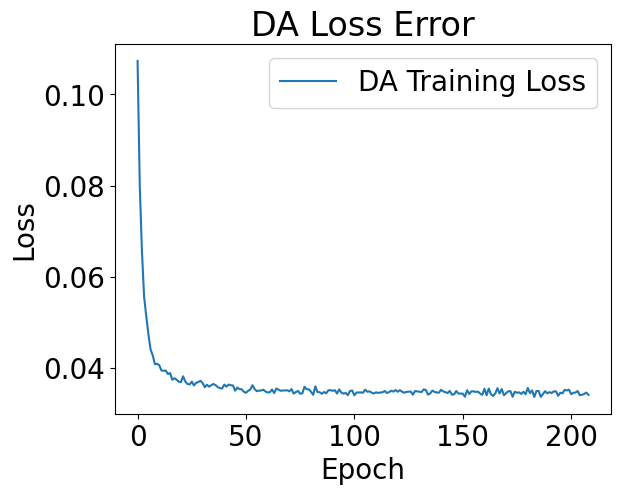

In [36]:
# DA Loss
fmt = lambda k: " ".join([i.capitalize() for i in k.split('_')])
eps = np.arange(stats["epoch_no"])
plt.title("DA Loss Error")
plt.plot(eps, stats['train_DA_loss'], label = "DA Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

(0.0, 0.05)

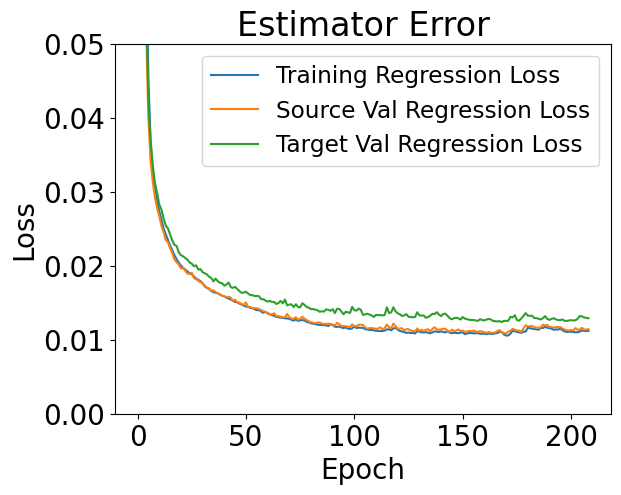

In [37]:
# Estimator / Regression
plt.title("Estimator Error")
plt.plot(eps, stats['train_regression_loss'], label = "Training Regression Loss")
plt.plot(eps, stats['val_source_regression_loss'], label = "Source Val Regression Loss")
plt.plot(eps, stats['val_target_regression_loss'], label = "Target Val Regression Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')
plt.ylim(0, 0.05)

(-2.0, 10.0)

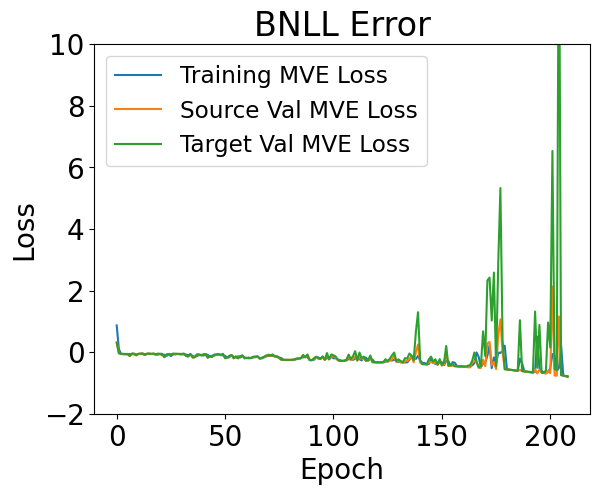

In [38]:
# BNLL for MVE
plt.title("BNLL Error")
plt.plot(eps, stats['train_mve_loss'], label = "Training MVE Loss")
plt.plot(eps, stats['val_source_mve_loss'], label = "Source Val MVE Loss")
plt.plot(eps, stats['val_target_mve_loss'], label = "Target Val MVE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')
plt.ylim(-2, 10)

(0.5, 1.0)

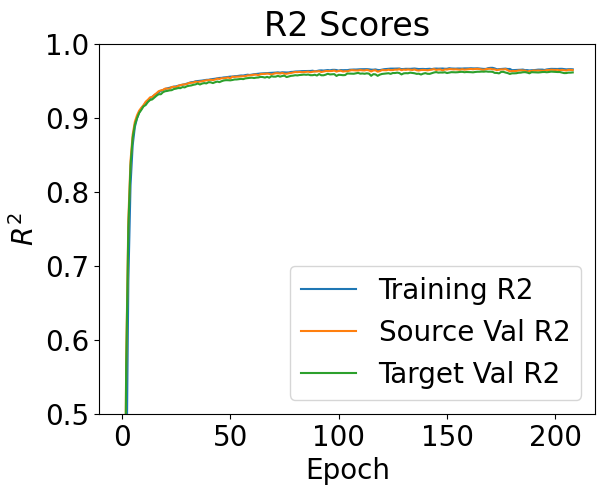

In [39]:
# R2 Scores
plt.title("R2 Scores")
plt.plot(eps, stats['train_r2_score'], label = "Training R2")
plt.plot(eps, stats['val_source_r2_score'], label = "Source Val R2")
plt.plot(eps, stats['val_target_r2_score'], label = "Target Val R2")
plt.xlabel("Epoch")
plt.ylabel("$R^2$")
plt.legend()
plt.ylim(0.5, 1)

In [40]:
# Test Source
var_preds_source = np.array([])
preds_source = np.array([])
true_source = np.array([])
lbnll_source = np.array([])
score_list = np.array([])

with torch.no_grad():
    for X, y in source_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_source = np.append(preds_source, pred[:, 0].cpu())
        var_preds_source = np.append(var_preds_source, pred[:, 1].cpu())
        true_source = np.append(true_source, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_source = np.append(lbnll_source, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))

score = np.mean(score_list)
print(f'Source R2 Score is {score:.4f}')

Source R2 Score is 0.9664


Text(0.5, 1.0, 'MMD | Source | R2: 0.966')

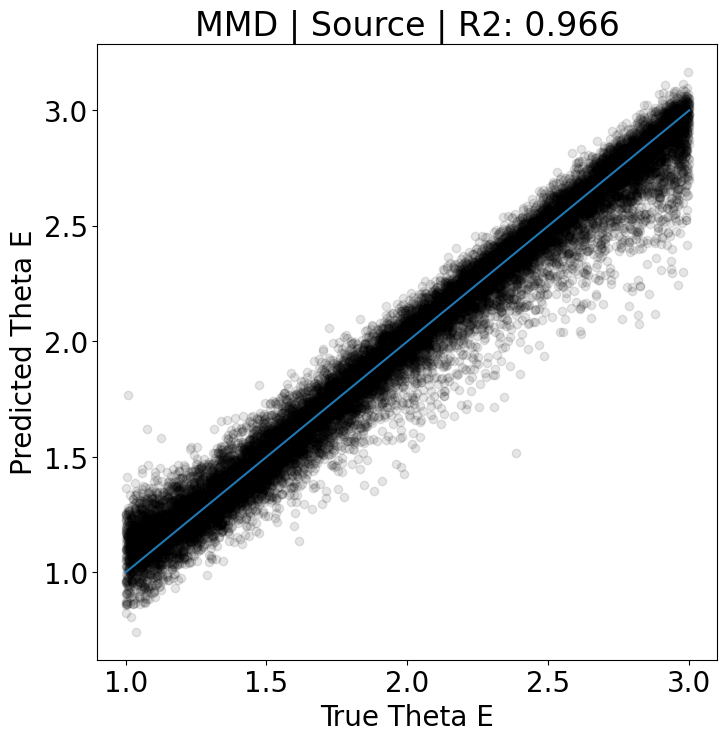

In [41]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, preds_source,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Source | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Source | BNLL: -0.323')

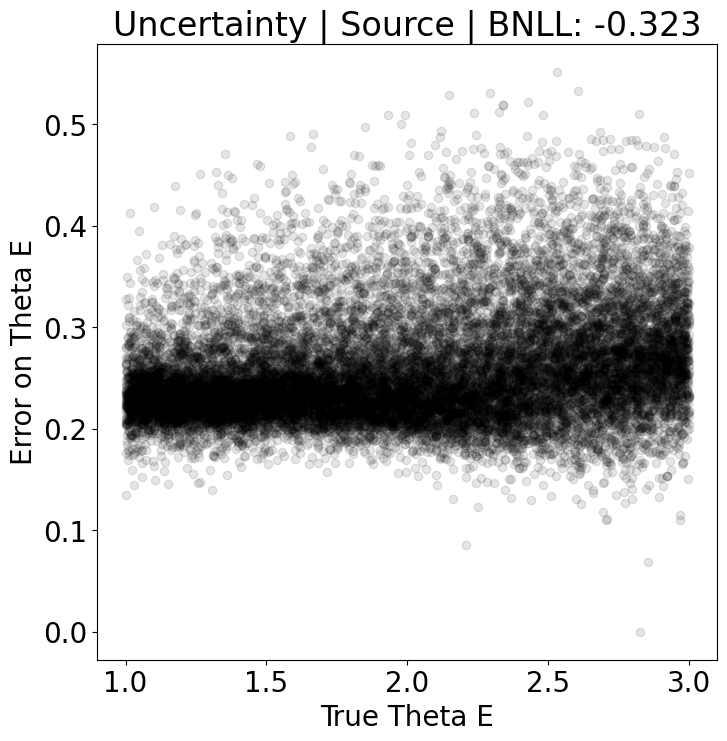

In [42]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, np.sqrt(var_preds_source),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Source | BNLL: {0:.3f}'.format(np.mean(lbnll_source)))

In [43]:
# Test target
preds_target = np.array([])
var_preds_target = np.array([])
true_target = np.array([])
score_list = np.array([])
lbnll_target = np.array([])


with torch.no_grad():
    for X, y in target_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_target = np.append(preds_target, pred[:, 0].cpu())
        var_preds_target = np.append(var_preds_target, pred[:, 1].cpu())
        true_target = np.append(true_target, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_target = np.append(lbnll_target, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))


score = np.mean(score_list)
print(f'Target R2 Score is {score:.4f}')

Target R2 Score is 0.9598


Text(0.5, 1.0, 'MMD | Target | R2: 0.960')

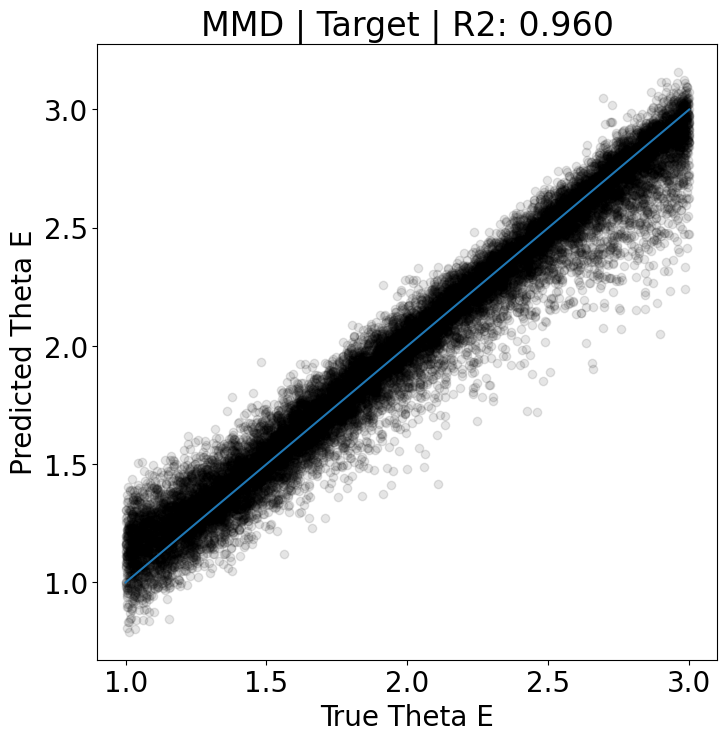

In [44]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, preds_target,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'MMD | Target | R2: 0.960')

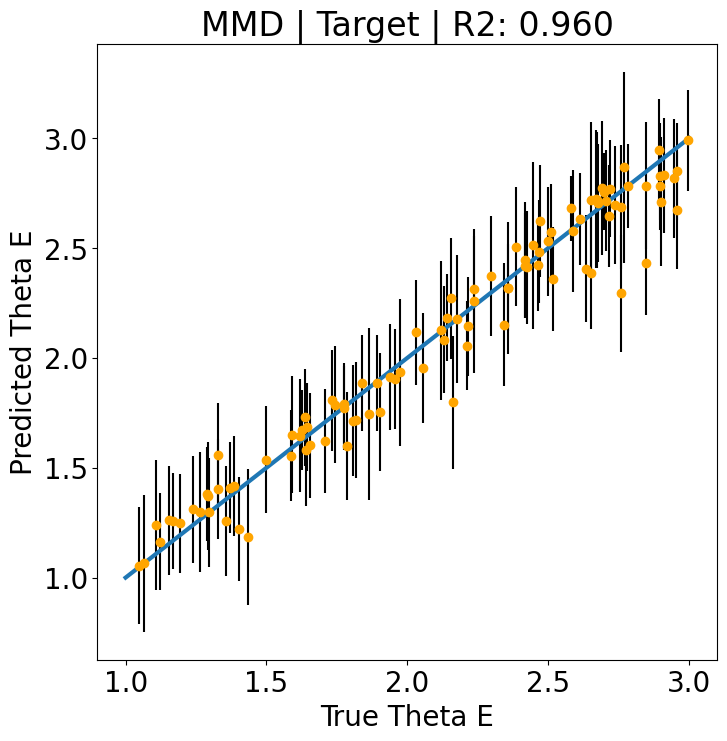

In [45]:
plt.figure(figsize=(8,8))
idx = np.random.choice(np.arange(len(true_target)), 100)
plt.errorbar(true_target[idx], preds_target[idx], yerr = np.sqrt(var_preds_target[idx]), fmt = 'o', color='orange', ecolor = 'k', alpha = 1)
line = np.linspace(1, 3, 100)
plt.plot(line, line, lw = 3)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Target | BNLL: -0.316')

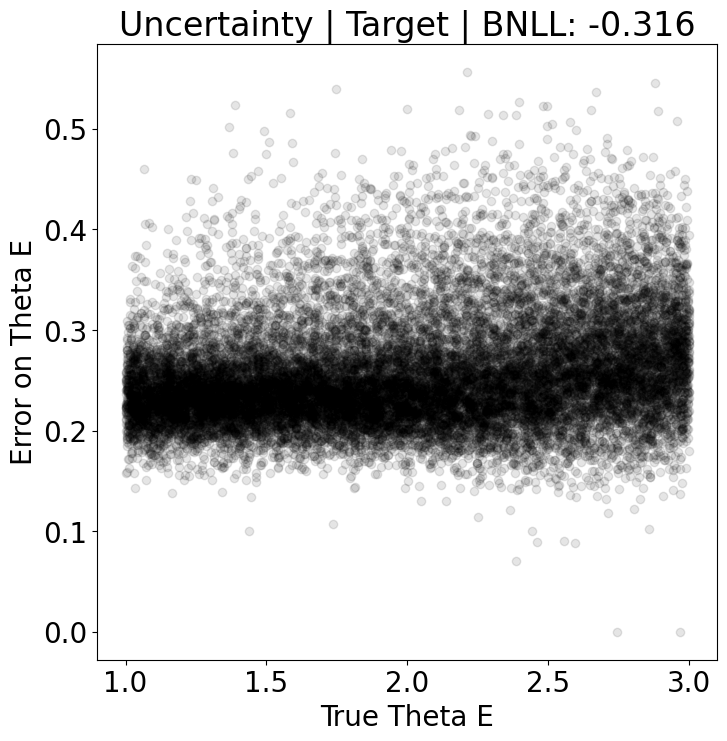

In [46]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, np.sqrt(var_preds_target),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Target | BNLL: {0:.3f}'.format(np.mean(lbnll_target)))

In [47]:
def sample_variance(obs, true):
    return np.std(obs - true) ** 2

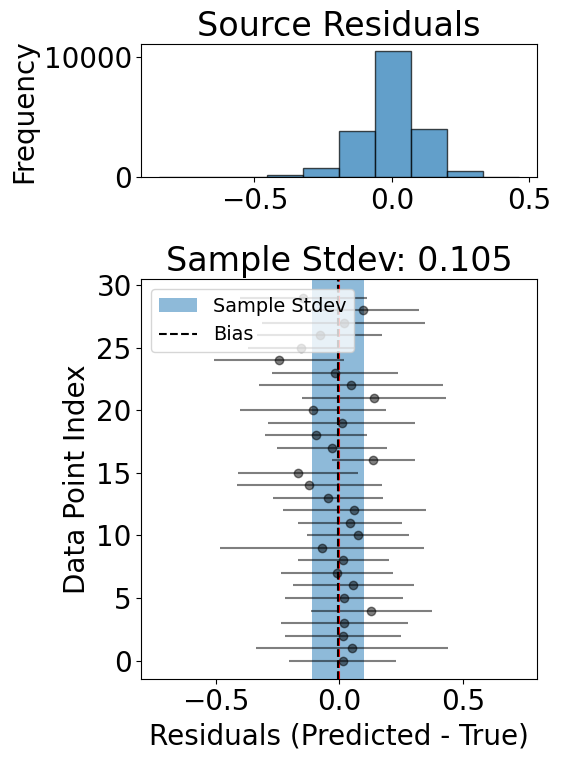

In [48]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_source[rand_idx] - true_source[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_source[rand_idx])
sv = np.sqrt(sample_variance(preds_source, true_source))
mn = np.mean(resid_all)

# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=10, edgecolor='black', alpha=0.7)
ax_hist.set_title('Source Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 'x-small')

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()

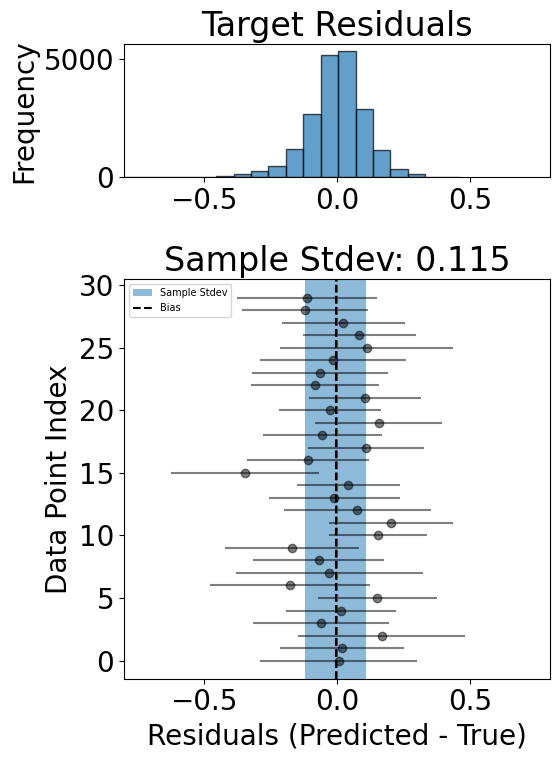

In [49]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_target[rand_idx] - true_target[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_target[rand_idx])
sv = np.sqrt(sample_variance(preds_target, true_target))
mn = np.mean(resid_all)
# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=20, edgecolor='black', alpha=0.7)
ax_hist.set_title('Target Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 7)
ax_resid.sharex(ax_hist)

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()